In [1]:
import subprocess
from pathlib import Path
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


%matplotlib notebook


PATH_CW = Path('/opt/ChipWhisperer-git/')

import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()
   
try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [2]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'

In [3]:
prog = cw.programmers.XMEGAProgrammer

In [4]:
path_fw = PATH_CW / "hardware/victims/firmware/simpleserial-power/simpleserial-power-{}.hex".format(PLATFORM)

In [5]:
import time
time.sleep(0.05)
scope.default_setup()
def reset_target(scope):
    scope.io.pdic = 'low'
    time.sleep(0.1)
    scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
    time.sleep(0.1) #xmega needs more startup time
    
scope

cwlite Device
fw_version = 
    major = 0
    minor = 20
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state      = True
    basic_mode = rising_edge
    timeout    = 2
    offset     = 0
    presamples = 0
    samples    = 5000
    decimate   = 1
    trig_count = 3158998125
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 96000000
    adc_rate      = 96000000.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1       = serial_rx
    tio2       = serial_tx
    tio3       = high_z
    tio4       = high_z
    pdid       = high_z
    pdic       = high_z
    nrst       = high_z
    glitch_hp  = False
    glitch_lp  = False
    extclk_src = hs1
    hs2        = clkgen
   

In [6]:
def firmware_compile(options):
    p = subprocess.run(
        "cp -rv simpleserial-power {path_cw}/hardware/victims/firmware/ && cd {path_cw}/hardware/victims/firmware/simpleserial-power && make PLATFORM={platform} {options} CRYPTO_TARGET=NONE | tail".format(
            platform=PLATFORM, path_cw=PATH_CW, options=options,
        ),
        capture_output=True,
        shell=True)
    print(p.stdout.decode('utf-8'))
    print(p.stderr.decode('utf-8'))

In [7]:
def upload():
    cw.program_target(
        scope,
        prog,
        str(path_fw))

In [8]:
def firmware_disassembly(fw, name_function):
    fw = str(fw)[:-3] + "elf"
    p = subprocess.run(
        "avr-objdump  -D --disassemble-zeroes {fw} | sed -n '/<{name}>:/,/^$/p'".format(fw=fw, name=name_function),
        capture_output=True,
        shell=True)
    print(p.stdout.decode('utf-8'))
    print(p.stderr.decode('utf-8'))

In [9]:
scope.adc.samples = 300
scope.adc.timeout = 5000

In [10]:
def capture_trace(scope):
    scope.arm()
    reset_target(scope)
    print(scope.capture())
    return scope.get_last_trace()

In [11]:
def plot_traces(traces: list):
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    ax.xaxis.set_major_locator(MultipleLocator(40))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

    # plt.minorticks_on()

    plt.grid()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    for trace, color, label in traces:
        plt.plot(trace, color=color, label=label)

    plt.legend()

    plt.show()

In [31]:
def plot_traces_by_side(traces: list):
    N = len(traces)
    
    fig = plt.figure(figsize=(8,3*N))

    for idx, (trace, color, label) in enumerate(traces):
        
    
        ax = plt.subplot(N, 1, idx + 1)
        ax.xaxis.set_major_locator(MultipleLocator(40))
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        plt.plot(trace, color=color, label=label)

        ax.grid()
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


    #fig.tight_layout()
    plt.show()

In [13]:
def capture_and_plot(scope, color, label):
    trace = capture_trace(scope)

    plot_traces([(trace, color, label)])
    
    return trace

In [14]:
def do(options, color, label):
    print('### {}'.format(label.upper()))
    firmware_compile(options)
    upload()
    firmware_disassembly(path_fw, "main")
    return capture_and_plot(scope, color, label)

### EMPTY
'simpleserial-power/.simpleserial-power.c.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.simpleserial-power.c.swp'
'simpleserial-power/makefile' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/makefile'
'simpleserial-power/simpleserial-power.c' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/simpleserial-power.c'
'simpleserial-power/.makefile.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.makefile.swp'
   1648	     16	     52	   1716	    6b4	simpleserial-power-CWLITEXMEGA.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite XMEGA with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = AES128C
+----------------------------

<IPython.core.display.Javascript object>


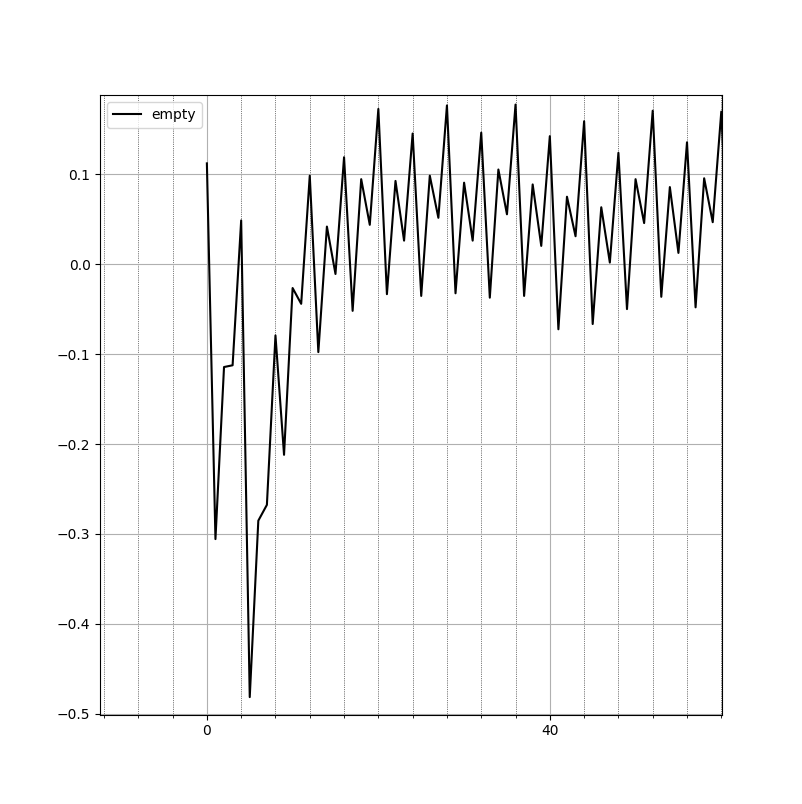

### NOP
'simpleserial-power/.simpleserial-power.c.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.simpleserial-power.c.swp'
'simpleserial-power/makefile' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/makefile'
'simpleserial-power/simpleserial-power.c' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/simpleserial-power.c'
'simpleserial-power/.makefile.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.makefile.swp'
   1668	     16	     52	   1736	    6c8	simpleserial-power-CWLITEXMEGA.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite XMEGA with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = AES128C
+------------------------------

<IPython.core.display.Javascript object>


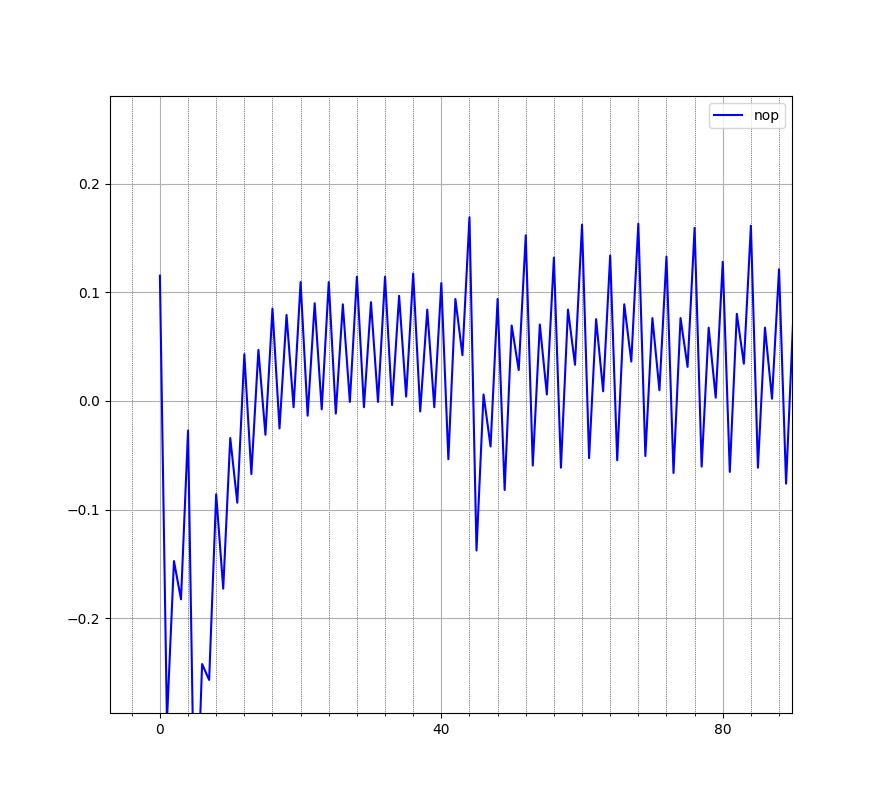

### MUL
'simpleserial-power/.simpleserial-power.c.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.simpleserial-power.c.swp'
'simpleserial-power/makefile' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/makefile'
'simpleserial-power/simpleserial-power.c' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/simpleserial-power.c'
'simpleserial-power/.makefile.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.makefile.swp'
   1668	     16	     52	   1736	    6c8	simpleserial-power-CWLITEXMEGA.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite XMEGA with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = AES128C
+------------------------------

<IPython.core.display.Javascript object>


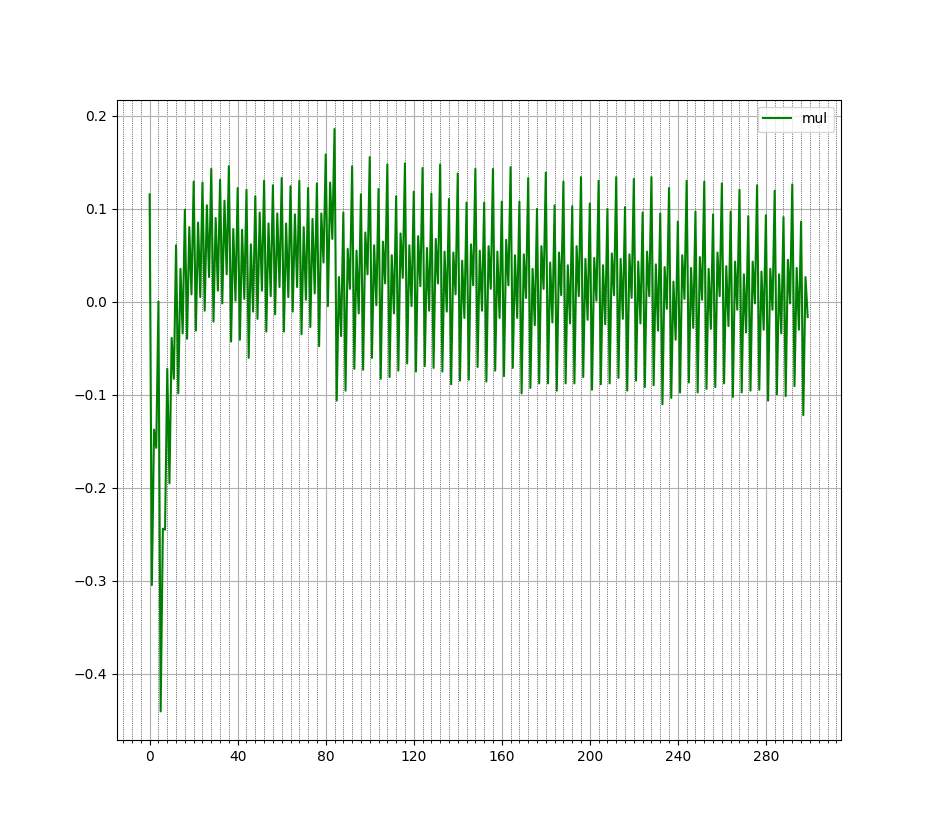

### MUL+MUL
'simpleserial-power/.simpleserial-power.c.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.simpleserial-power.c.swp'
'simpleserial-power/makefile' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/makefile'
'simpleserial-power/simpleserial-power.c' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/simpleserial-power.c'
'simpleserial-power/.makefile.swp' -> '/opt/ChipWhisperer-git/hardware/victims/firmware/simpleserial-power/.makefile.swp'
   1688	     16	     52	   1756	    6dc	simpleserial-power-CWLITEXMEGA.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite XMEGA with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = AES128C
+--------------------------

<IPython.core.display.Javascript object>


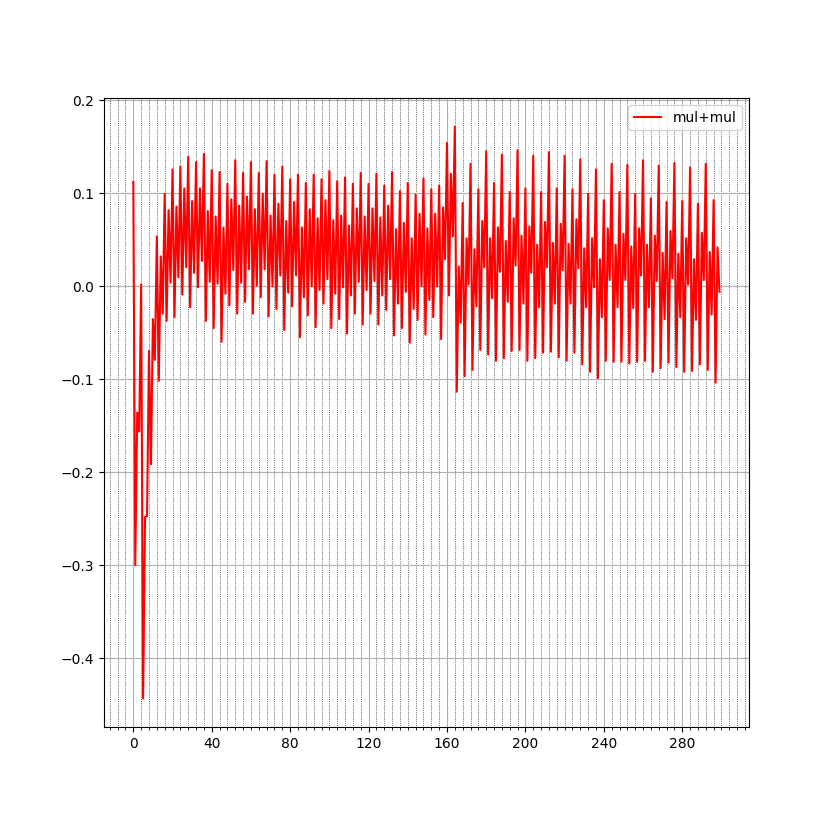

In [15]:
trace_empty = do("", 'black', 'empty')
trace_nop = do("NOP=1", 'b', 'nop')
trace_mul = do("MUL=1", 'g', 'mul')
trace_mul2 = do("MUL=1 MUL2=1", 'r', 'mul+mul')

<IPython.core.display.Javascript object>


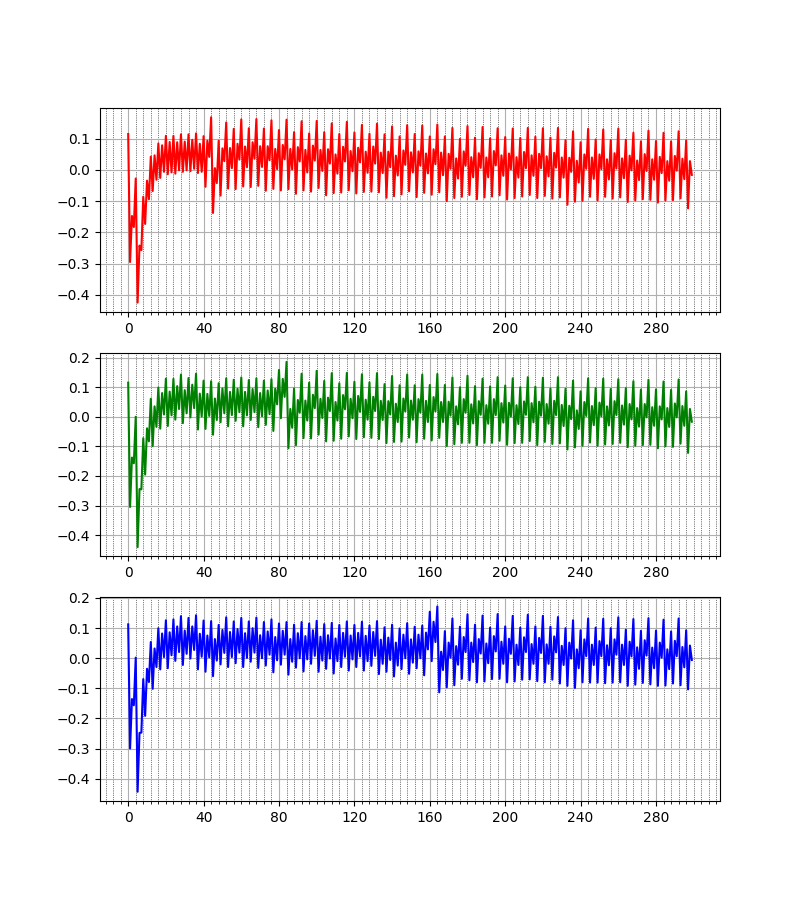

In [32]:
plot_traces_by_side([    
    (trace_nop, 'r', 'NOP'),
    (trace_mul, 'g', 'MUL'),
    (trace_mul2, 'b', 'MUL2'),
])

<IPython.core.display.Javascript object>


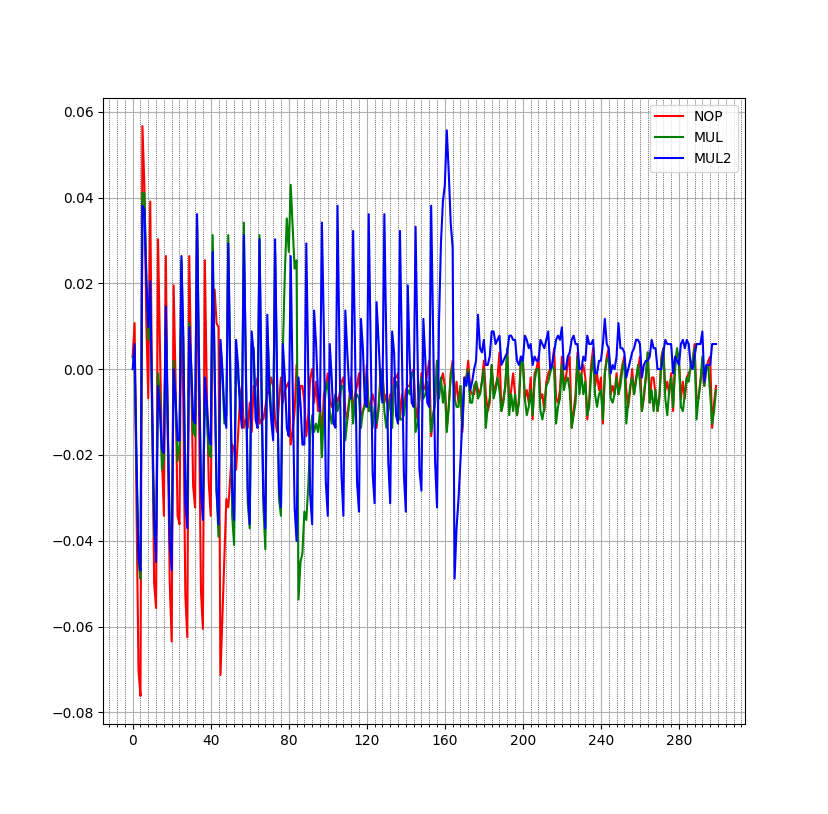

<IPython.core.display.Javascript object>


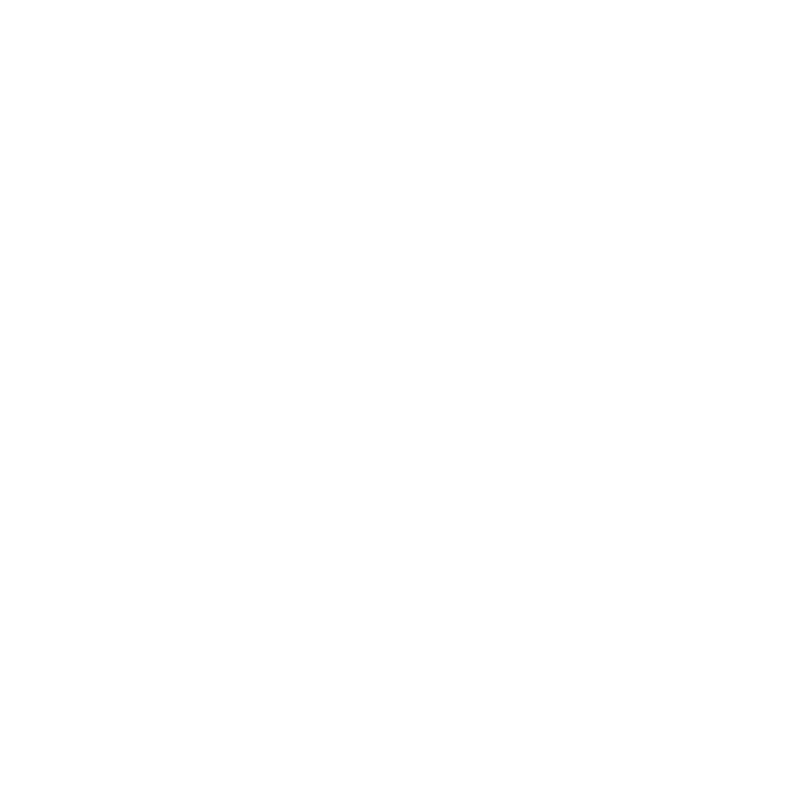

<IPython.core.display.Javascript object>


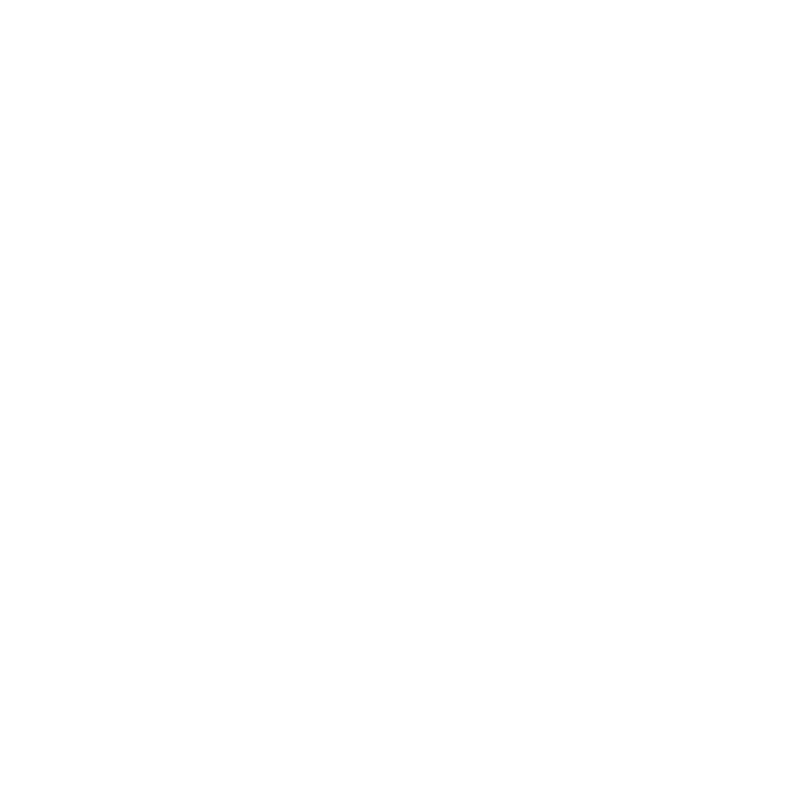

<IPython.core.display.Javascript object>


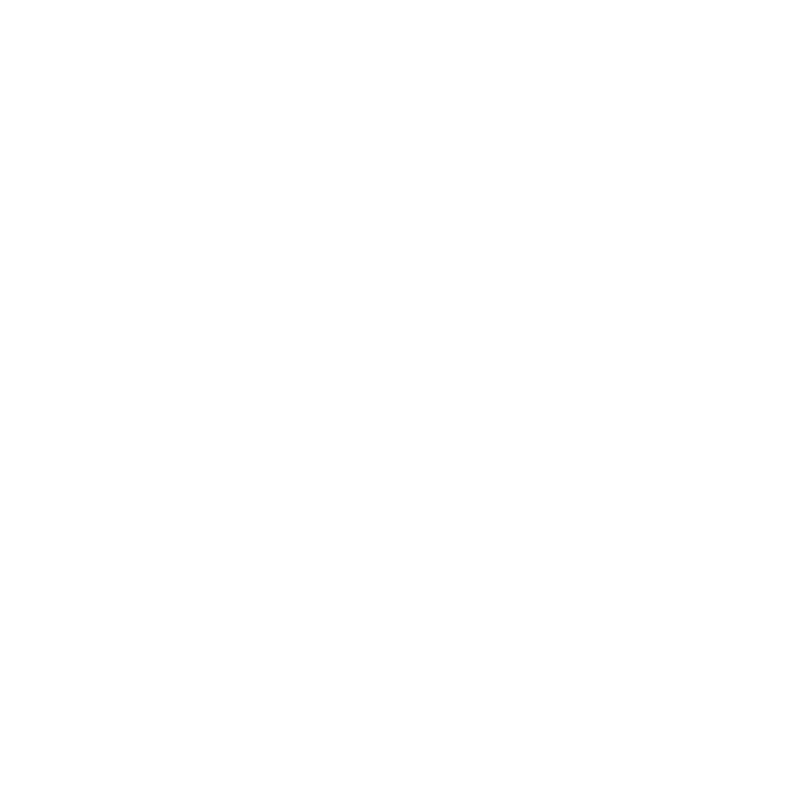

In [17]:
plot_traces([
    (trace_nop - trace_empty, 'r', 'NOP'),
    (trace_mul - trace_empty, 'g', 'MUL'),
    (trace_mul2 - trace_empty, 'b', 'MUL2'),
])
plot_traces([
    (trace_nop - trace_empty, 'r', 'NOP'),
    (trace_mul - trace_empty, 'g', 'MUL'),
])
plot_traces([
    (trace_mul - trace_empty, 'g', 'MUL'),
    (trace_mul2 - trace_empty, 'b', 'MUL2'),
])
plot_traces([
    (trace_nop - trace_mul, 'r', 'NOP - MUL'),
])